# Learning to Simulate an LIF Model
## November 3, 2025

The aspect of this project with which I am least familiar is in the numerical simulation of differential equations. Although I am familiar with the theory I have never learned much about numerical methods for solving ODE's. My first goal is to rigorously define what it is I am simulating mathematically, then explore the my resources for the appropriate numerical method.

### Dynamics

The basic component of the LIF model describing the change in membrane voltage is given by

$$
\tau \frac{d}{dt}V(t) = -(V(t) - V_\text{rest}) + R \space I(t)
$$

where we have


- $\tau = RC : \text{time constant of the circuit}$
- $V : \text{Membrane potential}$
- $V_\text{rest} : \text{Resting potential}$
- $R : \text{Resistance}$
- $I(t) : \text{Current}$


The second component of this model is the "fire" component, which generates a spike when the voltage reaches a chosen threshhold, and resets the voltage back to $V_\text{reset}$. Mathematically, for firing time $t^{f}$ and threshold $\vartheta$, a spike, or firing, occurs when

$$
V(t^{f}) = \vartheta.
$$

It follows that the spike train for a neuron $i$ can be expressed with the Dirac delta function:

$$
S_i(t) = \sum_f \delta (t - t_i^f)
$$

There are appropriate alternative representations for spikes that have different characteristics than those of the Dirac delta function.

### Numerical Methods

Some numerical methods we could look into using are [**Euler's method**](https://en.wikipedia.org/wiki/Euler_method) for simplicity or [**RK4**](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) for accuracy.

For example, using Euler's method, we choose our total time interval $[0, T_\text{total}]$, say $1$ second ($1000$ ms). Then we partition $[0, T_\text{total}]$ into equal discrete intervals of length $\Delta t$, say $\Delta t = 0.1$ ms. Then $V(t + \Delta t) = V(t) + \Delta t \cdot \frac{d}{dt} V(t)$.

### Parameters

For the parameters of the model, we will use biologically realistic values:

- $\tau = 10 \text{ ms}$
- $V_\text{rest} = -70 \text{ mV}$
- $R = 10\space \Omega$
- $\vartheta = -55 \text{mV}$
- $V_\text{reset} = -75 \text{mV}$

### First Attempt

Euler's method with constant $I$:

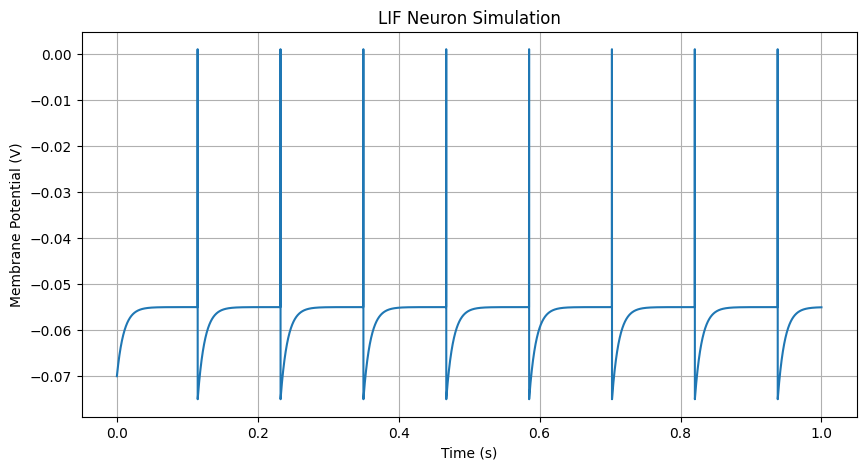

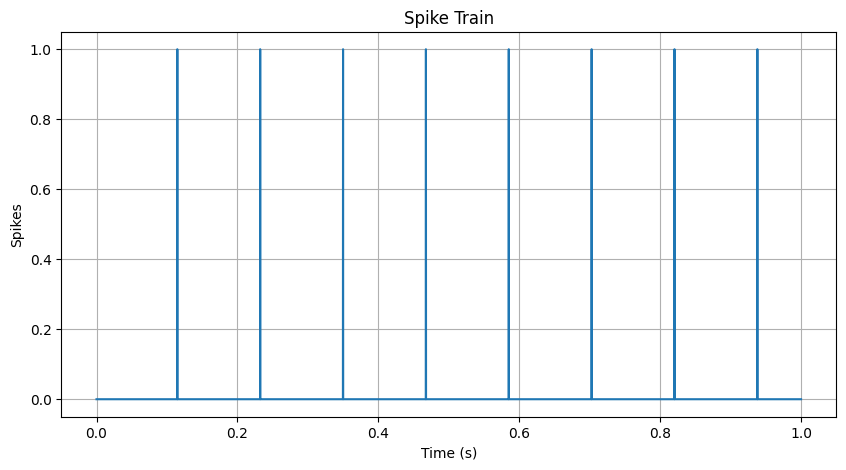

In [11]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(122)

TAU = 0.010
V_REST = -0.07
R = 10
THRESHOLD = -0.055
V_RESET = -0.075
V_SPIKE = 0.001

T_TOTAL = 1 
DELTA = 0.0001
time_steps = int(T_TOTAL / DELTA)

#initialize time and potential vectors
t = np.linspace(0, T_TOTAL, time_steps)
V = np.zeros(time_steps)
V[0] = V_REST

#we want to count the spikes and their time stamps for building S_i
spike_counts = 0
spike_times = np.zeros(time_steps)

#use constant value here
RI_input = 1.00001 * (THRESHOLD - V_REST)

for i in range(time_steps - 1):
    
    dV = (-(V[i] - V_REST) + RI_input) / TAU

    # 2. Euler step
    V[i+1] = V[i] + DELTA * dV

    # 3. Check for spike
    if V[i+1] >= THRESHOLD:
        V[i+1] = V_SPIKE

        spike_counts += 1
        spike_times[i+1] = 1

    if V[i] == V_SPIKE:
        V[i+1] = V_RESET


plt.figure(figsize=(10, 5))
plt.plot(t, V)
plt.title("LIF Neuron Simulation")
plt.xlabel("Time (s)")
plt.ylabel("Membrane Potential (V)")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 5))
plt.plot(t, spike_times)
plt.title("Spike Train")
plt.xlabel("Time (s)")
plt.ylabel('Spikes')
plt.grid(True)
plt.show()

Some notes:

- if RI is too low then no spike can occur

### Fire Rate:

If $N$ is the number of spikes in a given time interval, we have

$$
\text{Firing Rate } (Hz) = \frac{N}{t_\text{total}}
$$

Note that in general, $N = \int_0^{t_\text{total}} S_i(t) \space dt = \sum_f 1$.

In [12]:
fire_rate = spike_counts / T_TOTAL

print(f'Fire rate: {fire_rate} spikes per second.')

Fire rate: 16.0 spikes per second.


### What does a Poission current look like?

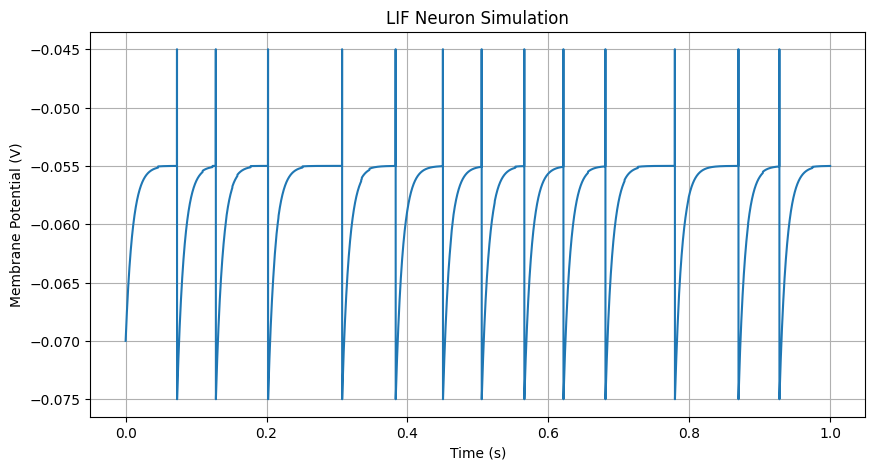

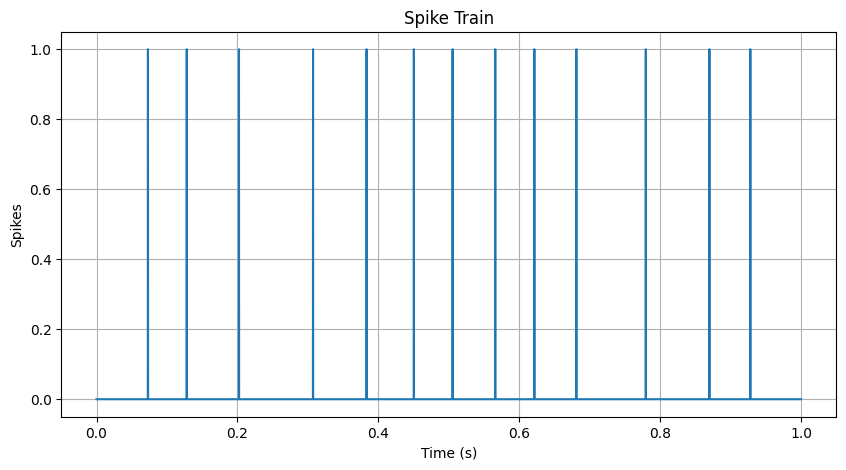

In [13]:
import numpy as np
from matplotlib import pyplot as plt

TAU = 0.010
V_REST = -0.07
R = 10
THRESHOLD = -0.055
V_RESET = -0.075
V_SPIKE = THRESHOLD + 0.01

T_TOTAL = 1 
DELTA = 0.0001
time_steps = int(T_TOTAL / DELTA)

# initialize time and potential vectors
t = np.linspace(0, T_TOTAL, time_steps)
V = np.zeros(time_steps)
V[0] = V_REST

# we want to count the spikes and their time stamps for building S_i
spike_counts = 0
spike_times = np.zeros(time_steps)

# use constant value plus poisson spike
rate_HZ = 50 # rate of background noise - x incoming spikes in voltage per second
weight = 0.01 # size of spike - 10 mV per spike

poisson_additive = np.random.default_rng().poisson(lam=rate_HZ*DELTA, size=time_steps) * weight
RI_input = 1.0000001 * (THRESHOLD - V_REST) + poisson_additive

for i in range(time_steps - 1):
    
    dV = (-(V[i] - V_REST) + RI_input[i]) / TAU

    # 2. Euler step
    V[i+1] = V[i] + DELTA * dV

    # 3. Check for spike
    if V[i+1] >= THRESHOLD:

        # artificial peak for visualization
        V[i+1] = V_SPIKE

        spike_counts += 1
        spike_times[i+1] = 1

    if V[i] == V_SPIKE:
        V[i+1] = V_RESET


plt.figure(figsize=(10, 5))
plt.plot(t, V)
plt.title("LIF Neuron Simulation")
plt.xlabel("Time (s)")
plt.ylabel("Membrane Potential (V)")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 5))
plt.plot(t, spike_times)
plt.title("Spike Train")
plt.xlabel("Time (s)")
plt.ylabel('Spikes')
plt.grid(True)
plt.show()

### Spike Train Kernel Density Estimation

We want to estimate the probability of a spike occuring in a small time interval $\Delta t$, so we do this by producing a kernel density estimation (KDE) of the spike train by convolving the spike train with a Gaussian distribtuion. The result is a smoothed version of the spike train.

Rather than assuming deterministic spike times we assume that the probability of a spike is normally distributed around its observed time.

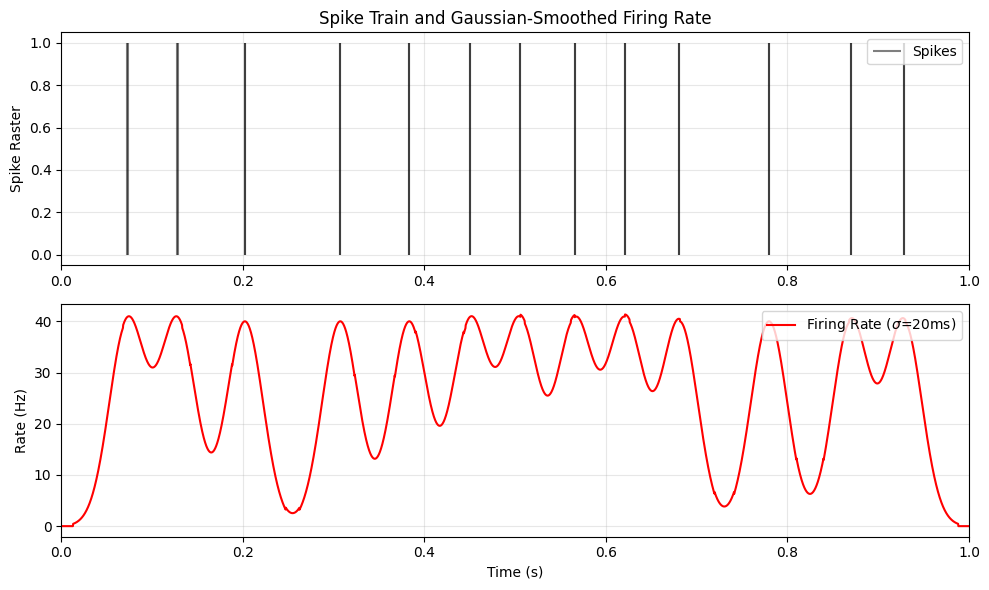

In [14]:
# 1. Define Gaussian Kernel
sigma_sec = 0.02  # 20 ms standard deviation for smoothing
sigma_bins = int(sigma_sec / DELTA)
k_width = sigma_bins * 6 + 1  # +/- 3 sigma covers >99% of the curve
k_time = np.arange(-k_width//2, k_width//2 + 1) * DELTA
kernel = np.exp(-k_time**2 / (2 * sigma_sec**2))
kernel = kernel / np.sum(kernel)  # Normalize kernel area to 1

# 2. Convolve
# mode='same' keeps the output the same length as 't'
firing_rate_hz = np.convolve(spike_times, kernel, mode='same') / DELTA

# 3. Plot
plt.figure(figsize=(10, 6))

# Plot Spikes (top panel)
plt.subplot(2, 1, 1)
# Use vlines for cleaner spike raster visualization
plt.vlines(t[spike_times == 1], ymin=0, ymax=1, color='k', alpha=0.5, label='Spikes')
plt.ylabel("Spike Raster")
plt.title("Spike Train and Gaussian-Smoothed Firing Rate")
plt.xlim(0, T_TOTAL)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

# Plot Firing Rate
plt.subplot(2, 1, 2)
plt.plot(t, firing_rate_hz, color='r', label=f'Firing Rate ($\\sigma$={sigma_sec*1000:.0f}ms)')
plt.xlabel("Time (s)")
plt.ylabel("Rate (Hz)")
plt.xlim(0, T_TOTAL)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Network Structure

The main question of this project is whether the neural network structure, more specifically the presence of long and short connections, affects neuronal synchronicity. The ideal model for this is the small-world model of Watts and Strogatz. The procedure goes as follows. Start with a perfectly local graph then rewire vertices at random. With this construction we can see how the network dynamics change as we rewire vertices.

Perfectly local structure:

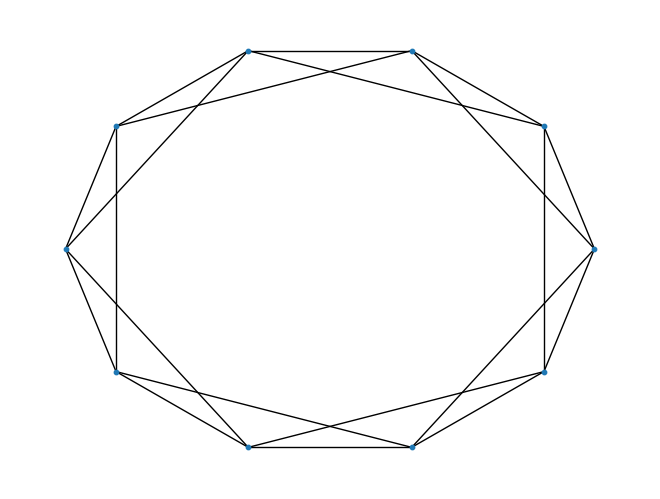

In [15]:
import networkx as nx

n = 10 # total number of nodes
k = 4 # number of neighbors to connect to
p = 0 # probability of rewiring

G = nx.watts_strogatz_graph(n, k, p)

def in_a_circle(g:nx.Graph, r):
    """
    Nodes are labeled 0, 1, ..., n-1 where n is the number of nodes.
    Compute i/n * 2pi then convert to Cartesian coords for plotting.
    Returns a dictionary in the format {node: coordinate}
    """
    n = g.number_of_nodes()
    coords = []
    for i in g.nodes:
        angle = int(i)/n * 2 * np.pi
        cartesian = (r*np.cos(angle), r*np.sin(angle))
        coords.append(cartesian)

    position = dict(zip(list(g.nodes), coords))

    return position



nx.draw(G, node_size = 10, pos=in_a_circle(G, 1))

When we rewire each edge at random with probability 0.5, we get the following.

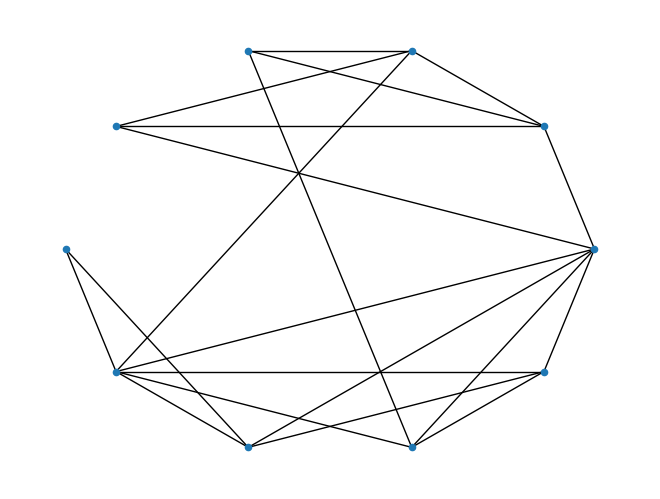

In [16]:
n = 10 # number of vertices
k = 4 # number of neighbors to initially connect each node to
p = 0.5 # rewiring probability

H = nx.watts_strogatz_graph(n, k, p)

nx.draw(H, node_size = 20, pos=in_a_circle(H, 1))

Each node in the network represents one neuron, and an edge represents a synaptic connection. This allows the electrical activity of a neuron to influence that of its neighbors.

The next important decision to make here is to determine how best to choose edge directions and weights. After looking into it, it seems that neurons are typically either excitatory or inhibitory neurons with positive and negative edge weights, respectively. I need to figure out the best way to set this up.

Once we obtained a weighted directed graph for the network structure, we can extract its adjacency matrix like so. This particular graph is undirected and unweighted so its components will be in {0, 1} and the matrix is symmetric

In [17]:
nx.to_numpy_array(G)

array([[0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       [1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]])

We implement the LIF model for each neuron as we did above, but this time we write the current term $R\space I(t)$ for each neuron as the sum of the voltages of its neighbors, multiplied by the synaptic weight that we will determine. If $A$ is the adajency matrix of the directed weighted graph, then we have the equation:

$$
\tau \frac{d}{dt}V_i(t) = -(V_i(t) - V_\text{rest}) + \overbrace{\sum_j^n A_{ij} S_j(t)}^\text{integrated inputs} + \overbrace{R\space I_i(t)}^\text{indepent input},\\

\text{where}\quad 
S_j(t) = \sum_f \delta(t - t_j^{f})\quad \text{is the spike train for neuron } j.
$$

In matrix form, we have

$$
\tau \frac{d}{dt} \textbf{V} = - \textbf{V} + \textbf{1}V_\text{rest} + \textbf{AS} + R\space \textbf{I}.
$$

Descretizing with Euler's method again, we obtain the following approximation:

$$
\textbf{V}(t + \Delta t) = \textbf{V(t)} + \Delta t \cdot \frac{d}{dt} \textbf{V}(t)
$$

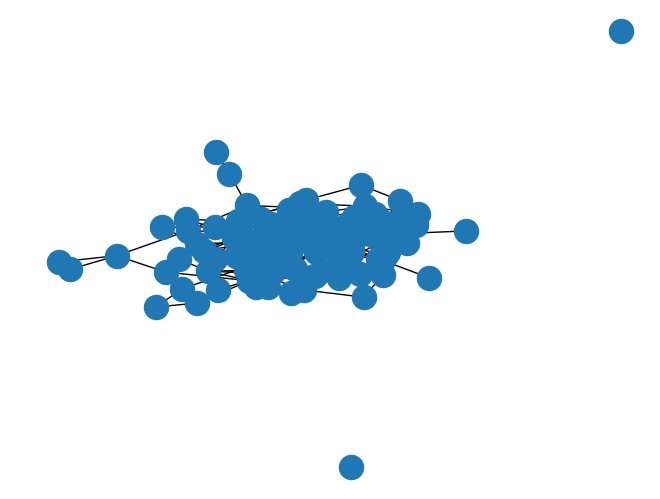

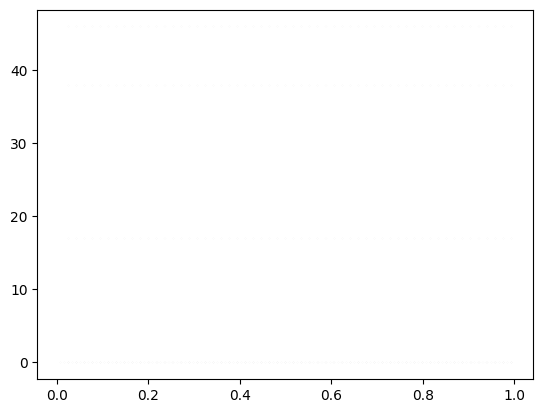

In [63]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

np.random.seed(122)

# --- 1. Network Setup ---
G = nx.gnm_random_graph(100, 200)
nx.draw(G)
plt.show()
N = G.number_of_nodes()
A = nx.to_numpy_array(G)

# We need a *weighted* adjacency matrix, W (our 'A' from the math)
# Let's set a uniform synaptic weight. This is the "kick" a spike gives.
# This value is crucial and you'll need to tune it.
SYNAPTIC_WEIGHT = 0.5
W = A * SYNAPTIC_WEIGHT 

# --- 2. Model Parameters (same as before) ---
TAU = 0.010       # Membrane time constant (s)
V_REST = -0.070   # Resting potential (V)
R = 10            # Resistance (Ohm) - not really used here
THRESHOLD = -0.055 # Spike threshold (V)
V_RESET = -0.075  # Reset voltage (V)
V_SPIKE = 0.001   # Voltage to "draw" the spike (V)

# --- 3. Simulation Time ---
T_TOTAL = 1 
DELTA = 0.0001    # Time step (s)
time_steps = int(T_TOTAL / DELTA)

# initialize time
t = np.linspace(0, T_TOTAL, time_steps)

# --- 4. Vectorize Variables ---
# V is now an N x time_steps matrix
V = np.zeros((N, time_steps))
V[:, 0] = V_REST # Set all neurons to V_REST at t=0

# S is our spike train matrix (N x time_steps)
# This is spike_times from your code, but for N neurons
S_matrix = np.zeros((N, time_steps))

# --- 5. The Main Loop (Vectorized) ---
for i in range(time_steps - 1):
    
    # 1. Get the spike vector S(t) from the *previous* time step
    # Your old code used spike_times[i+1], so we use S_matrix[:, i]
    # (Note: for t=0, S_matrix[:, 0] is all zeros, which is correct)
    S_vec = S_matrix[:, i]
    
    # 2. Calculate the total synaptic input for all neurons
    # This is the matrix multiplication AS (or W*S) from our equation
    synaptic_input = W @ S_vec

    # Give a starting node some current to work with
    RI_vector = np.zeros(N)
    RI_vector[0] = 2 * (THRESHOLD - V_REST)

    # 3. Calculate dV/dt for ALL neurons at once
    # This is the full vectorized LIF equation
    dV = (-(V[:, i] - V_REST) + RI_vector + synaptic_input) / TAU

    # 4. Euler step for ALL neurons
    V[:, i+1] = V[:, i] + DELTA * dV

    # 5. Find which neurons are spiking and which need to be reset
    # We use boolean arrays for efficient, vectorized checks
    spiking_neurons = V[:, i+1] >= THRESHOLD
    reset_neurons = V[:, i] == V_SPIKE # Check *previous* state, like your code
    
    # 6. Apply spike and reset logic
    # Set spiking neurons to V_SPIKE
    V[spiking_neurons, i+1] = V_SPIKE
    
    # Set neurons that *just* spiked to V_RESET
    # This overwrites the V_SPIKE value for the *next* time step
    V[reset_neurons, i+1] = V_RESET
    
    # 7. Record the spikes in our spike matrix S
    S_matrix[spiking_neurons, i+1] = 1


# visualize S_matrix
# 1. Find all (row, col) coordinates where S_matrix is 1
neuron_indices, time_indices = np.where(S_matrix == 1)

# 2. Convert the 'col' coordinates (time_indices) into actual time in seconds
spike_times_sec = t[time_indices]

# 3. 'neuron_indices' are already the 'y' coordinates.
#    'spike_times_sec' are now the 'x' coordinates.
#    Now, plot them.
plt.scatter(spike_times_sec, neuron_indices, marker='.', s= 0.0001, color='black')
plt.show()

In [64]:
S_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(100, 10000))

This is incredibly difficult to actually compute numerically. I may need to find a workaround.